In [12]:
#changelog: 

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torcheval.metrics import MulticlassConfusionMatrix
from torch.optim import lr_scheduler

from skorch import NeuralNetClassifier

from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold, cross_validate, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import os
import yaml
from operator import itemgetter

import math

import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
pd.set_option('display.max_columns', None)

ckd_df = pd.read_excel(
    "Data/ckd_dataset.xlsx",
    usecols = "B:W,AL:AQ,AS:AY"
)

#filtering
def ckd_stage_clf(eGFR):
    if eGFR >= 90:
        return 0 #stage 1
    elif eGFR >= 60:
        return 1 #stage 2
    elif eGFR >= 45:
        return 2 #3a
    elif eGFR >= 30:
        return 3 #3b
    elif eGFR >= 15:
        return 4 #stage 4
    else:
        return 5


ckd_df.dropna(inplace=True)
eGFR_final_mean = ckd_df["eGFR(last visit)"].mean()
eGFR_final_std = ckd_df["eGFR(last visit)"].std()
filtered_ckd_df = ckd_df[(ckd_df["eGFR(last visit)"] < (eGFR_final_mean + 3*eGFR_final_std)) & (ckd_df["eGFR(last visit)"] < (.95 * ckd_df["eGFR"]))]
#filtered_ckd_df = ckd_df[(ckd_df["eGFR(last visit)"] < (eGFR_final_mean + 3*eGFR_final_std))]
filtered_ckd_df.loc[:, "CKD_stage"] = filtered_ckd_df.loc[:, "eGFR"].apply(ckd_stage_clf)

filtered_ckd_df

,gender,age,SBP,BMI,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,CKD category,dip-stick proteinuria,proteinuria,urinary occult blood,UPCR,UPCR category,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,eGFR(last visit),observational duration,50%eGFR_reached,50%eGFR_duration,RRT,RRT_duration,CKD progression,CKD progression_duration,death,death_duration,development of CVD,development of CVD_duration,≥6M followed
0,2,74,120.0,23.137669,2,12.0,4.0,1.20,34.146986,3,6.0,2.0,1.0,0.0,1.253731,3.0,1,0,0,1,1,0,18.495328,37,0,37,0,37,0,37,0,37,0,37,1
2,1,74,143.0,24.554564,2,10.9,3.8,4.95,9.804696,5,12.0,3.0,1.0,0.0,1.759615,3.0,1,0,1,1,1,1,5.578057,13,0,13,1,13,1,13,0,13,0,13,1
3,1,57,139.0,28.515625,2,15.9,4.8,0.84,73.570568,1,4.0,1.0,1.0,0.0,0.513514,3.0,1,0,0,0,0,0,67.225032,37,0,37,0,37,0,37,0,37,0,37,1
4,1,32,154.0,24.582701,4,14.4,4.4,0.87,83.558305,1,1.0,-1.0,0.0,0.0,0.025000,1.0,1,0,0,0,0,0,69.171408,36,0,36,0,36,0,36,0,36,0,36,1
7,1,66,148.0,22.532285,1,10.2,3.3,5.39,9.230697,5,12.0,3.0,1.0,0.0,3.535088,3.0,1,0,1,0,1,1,8.403298,6,0,6,1,8,1,8,0,8,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,1,75,120.0,26.015635,1,11.2,3.9,2.56,20.092993,4,8.0,-1.0,0.0,0.0,0.210210,2.0,1,0,1,1,1,0,15.511510,37,0,37,0,37,0,37,0,37,0,37,1
1128,2,72,169.0,22.494988,1,6.6,2.7,3.12,12.100035,5,12.0,3.0,1.0,0.0,17.298091,3.0,1,0,1,0,1,0,9.285258,7,0,7,1,10,1,10,0,10,0,7,1
1131,1,71,154.0,24.238775,2,15.4,4.2,1.08,52.471683,2,6.0,2.0,1.0,0.0,0.760234,3.0,1,0,0,1,0,0,47.952934,38,0,38,0,38,0,38,0,38,0,38,1
1132,1,81,154.0,19.596458,2,9.0,3.5,2.00,25.747776,4,9.0,2.0,1.0,0.0,1.038526,3.0,1,1,0,1,1,1,17.923736,37,0,37,0,37,0,37,0,37,0,37,1


In [13]:
#loading in hyperparameters from yaml

#create hyperparameters for learning rate scheduler
with open("nn_hyperparameters.yaml", "r") as file:
    hyperparameters = yaml.safe_load(file)

model_hyperparameters = hyperparameters["model"]
training_hyperparameters = hyperparameters["training"]
input_size, hidden_size, output_size, dropout_prob = itemgetter("input_size",
                                                                "hidden_size",
                                                                "output_size", 
                                                                "dropout_prob")(model_hyperparameters)

fold_count, epoch_count, batch_size, learning_rate, weight_decay, patience = itemgetter("fold_count", 
                                                                                        "epoch_count", 
                                                                                        "batch_size", 
                                                                                        "learning_rate", 
                                                                                        "weight_decay", 
                                                                                        "patience")(training_hyperparameters)

In [14]:
#loading in the dataset

scaler = MinMaxScaler()
x_vals = filtered_ckd_df.drop(columns=["gender",
                                       "age",
                                       "Cr",
                                       "eGFR",
                                       "CKD_stage",
                                       "eGFR(last visit)"]).values
norm_x_vals = scaler.fit_transform(x_vals)

class ckdDataset(Dataset):
    def __init__(self):
        self.data = filtered_ckd_df
        self.x = torch.tensor(norm_x_vals,
                              dtype=torch.float32,
                              device=device,
                              requires_grad=True)
        self.y = torch.tensor(filtered_ckd_df.loc[:, "CKD_stage"].values,
                              dtype=torch.float32,
                              device=device,
                              requires_grad=True)
        self.y = self.y.type(torch.long)
        self.x_size = self.x.size
        self.y_size = self.y.size
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x,
                                                                                self.y,
                                                                                test_size=0.2)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

ckd_dataset = ckdDataset()

In [15]:
#creating neural net

def weight_init(layer):
    if isinstance(layer, nn.Linear):
        init.kaiming_uniform_(layer.weight)

class ckdNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(in_features=hidden_size, out_features=input_size),
            nn.ReLU(),
            nn.BatchNorm1d(input_size) # think the relu and batch norm is necessary b/c theres a linear at the end
        )
        self.classifier = nn.Linear(in_features=input_size, out_features=output_size)

        self.apply(weight_init)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        out += x # res connection
        return self.classifier(out)

In [16]:
#training functions
training_loss_list = []
testing_loss_list = []
fold_accuracies = []

def nnBatchTraining(model, optimizer, dataloader):
  model.train()
  for x_batch, y_batch in dataloader:
        y_train_pred = model(x_batch)
        training_loss = loss_func(y_train_pred, y_batch)
        optimizer.zero_grad()
        training_loss.backward(retain_graph=True)
        optimizer.step()
  training_loss = training_loss.item()
  training_loss_list.append(training_loss)
  return training_loss

def nnTestingLoop(model, train_dataset, test_dataset, mean_testing_loss_list):
  model.eval()
  with torch.inference_mode():
    y_test_pred = model(train_dataset)
    testing_loss = loss_func(y_test_pred, test_dataset)

  testing_loss = testing_loss.item()
  testing_loss_list.append(testing_loss)
  mean_testing_loss_list.append(testing_loss)
  mean_testing_loss = np.mean(mean_testing_loss_list)
  return testing_loss, mean_testing_loss

def nnAccuracyLoop(model, dataloader):
  model.eval()
  correct = 0
  total = 0
  with torch.inference_mode():
    for x_batch, y_batch in dataloader:
      y_test_pred = model(x_batch)
      y_test_pred = torch.argmax(y_test_pred, dim=1)
      total += y_batch.size(0)
      correct += (y_test_pred == y_batch).sum().item()

  accuracy = correct/total
  fold_accuracies.append(accuracy)
  print(f"Accuracy for Fold {fold+1}: {accuracy}")

def nnLRSchedulerStep(scheduler_1, scheduler_2):
  scheduler_2.step()
  if epoch > 4:
    scheduler_1.step()

def earlyStopper(model, optimizer, epoch, best_testing_loss, mean_testing_loss, epochs_without_improvement, checkpoint_path):
  if (best_testing_loss) > mean_testing_loss:
    best_testing_loss = mean_testing_loss
    epochs_without_improvement = 0
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training loss": training_loss,
        "test loss": testing_loss
    }
    torch.save(checkpoint, checkpoint_path)
  else:
    epochs_without_improvement += 1
    print(f"Epochs without improvement: {epochs_without_improvement}, Epoch: {epoch+1}")

  return epochs_without_improvement, best_testing_loss

In [17]:
#sci-kit cross val version
#idk if this counts anymore bro
scikit_loss_list = []
scikit_loss_per_fold = []

class ckdCompatibleNeuralNetwork(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = ckdNeuralNetwork(input_size, hidden_size, output_size, dropout_prob)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    def fit(self, x, y):
        self.classes_ = np.unique(ckd_dataset.y)
        dataset = TensorDataset(ckd_dataset.x, ckd_dataset.y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.model.train()
        for epoch in range(epoch_count):
            for x_batch, y_batch in dataloader:
                y_train_pred = self.model(x_batch)
                loss = self.loss_func(y_train_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward(retain_graph=True)
                self.optimizer.step()
            if (epoch+1) % 10 == 0:
              print(f"Epoch: {epoch+1}, Loss: {loss}")
            loss = loss.item()
            scikit_loss_list.append(loss)
        scikit_loss_per_fold.append(loss)

        return self

    def predict(self, x):
        self.model.eval()
        with torch.inference_mode():
            y_test_pred = self.model(x)
        predicted = torch.argmax(y_test_pred, dim=1)
        return predicted.numpy()

    def predict_proba(self, x):
        self.model.eval()
        with torch.inference_mode():
            y_test_pred = self.model(x)
        probabilities = F.softmax(y_test_pred, dim=1)
        return probabilities.numpy()


#ckd_model.to(device) 
ckd_model = ckdCompatibleNeuralNetwork()
# ckd_model.fit(ckd_dataset.x, ckd_dataset.y)
# kfold = StratifiedGroupKFold(n_splits=fold_count)
metrics = cross_validate(ckd_model,
                         ckd_dataset.x,
                         ckd_dataset.y,
                         cv=10,
                         scoring="accuracy",
                         return_train_score=True,
                         error_score='raise')

mean_train_score = np.mean(metrics["train_score"])
mean_test_score = np.mean(metrics["test_score"])

print(f"Metrics: {metrics}")
print(f"Mean Train Accuracy: {mean_train_score}")
print(f"Mean Test Accuracy: {mean_test_score}")

Epoch: 10, Loss: 0.42514729499816895
Epoch: 20, Loss: 0.12484875321388245
Epoch: 30, Loss: 0.34144124388694763
Epoch: 40, Loss: 0.30134299397468567
Epoch: 50, Loss: 0.22729693353176117
Epoch: 10, Loss: 0.36102810502052307
Epoch: 20, Loss: 0.19609518349170685
Epoch: 30, Loss: 0.1800348162651062
Epoch: 40, Loss: 0.14582397043704987
Epoch: 50, Loss: 0.6443146467208862
Epoch: 10, Loss: 0.37137284874916077
Epoch: 20, Loss: 0.12123162299394608
Epoch: 30, Loss: 0.25152388215065
Epoch: 40, Loss: 0.2408301681280136
Epoch: 50, Loss: 0.26425817608833313
Epoch: 10, Loss: 0.24909132719039917
Epoch: 20, Loss: 0.15024584531784058
Epoch: 30, Loss: 0.1832730770111084
Epoch: 40, Loss: 0.23288367688655853
Epoch: 50, Loss: 0.23453468084335327
Epoch: 10, Loss: 0.4921983778476715
Epoch: 20, Loss: 0.1525457352399826
Epoch: 30, Loss: 0.10289419442415237
Epoch: 40, Loss: 0.5425507426261902
Epoch: 50, Loss: 0.08740594983100891
Epoch: 10, Loss: 0.3499476909637451
Epoch: 20, Loss: 0.3349137306213379
Epoch: 30, Lo

In [18]:
#training

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

#early stopping vars

loss_func = nn.CrossEntropyLoss()

#checkpointing
checkpoint_dir = Path("./checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "model_checkpoint.pth"

#k-fold cross val
kf = StratifiedKFold(n_splits=fold_count, shuffle=True)

for fold, (train_index, test_index) in enumerate(kf.split(ckd_dataset.x, ckd_dataset.y)):
  #somehow save the model with best fold accuracy?
  best_testing_loss = float('inf')
  epochs_without_improvement = 0
  mean_testing_loss = 0
  mean_testing_loss_list = []

  print(f"Fold: {fold+1}")
  x_train, x_test = ckd_dataset.x[train_index], ckd_dataset.x[test_index]
  y_train, y_test = ckd_dataset.y[train_index], ckd_dataset.y[test_index]

  train_dataset = TensorDataset(x_train, y_train)
  test_dataset = TensorDataset(x_test, y_test)

  train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True)
  test_dataloader = DataLoader(dataset=test_dataset,
                               batch_size=batch_size,
                               shuffle=True)

  ckd_model = ckdNeuralNetwork(input_size, hidden_size, output_size, dropout_prob)
  ckd_model.to(device)

  optimizer = optim.AdamW(ckd_model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)

  scheduler_1 = lr_scheduler.LinearLR(optimizer,
                                      start_factor=1,
                                      end_factor=0.1,
                                      total_iters=25)

  scheduler_2 = lr_scheduler.LinearLR(optimizer,
                                      start_factor=0.1,
                                      end_factor=1,
                                      total_iters=5)


  for epoch in range(epoch_count):
    training_loss = nnBatchTraining(ckd_model, optimizer, train_dataloader)
    testing_loss, mean_testing_loss = nnTestingLoop(ckd_model, x_test, y_test, mean_testing_loss_list)

    #nnLRSchedulerStep(scheduler_1, scheduler_2)

    if (epoch + 1) % 10 == 0:
      print(f"Epoch: {epoch+1}, Training Loss: {training_loss}, Testing Loss: {testing_loss}")

    epochs_without_improvement, best_testing_loss = earlyStopper(ckd_model,
                                                                 optimizer,
                                                                 epoch,
                                                                 best_testing_loss,
                                                                 mean_testing_loss,
                                                                 epochs_without_improvement,
                                                                 checkpoint_path)

    if epochs_without_improvement >= patience:
      print("Early stop")
      break

  nnAccuracyLoop(ckd_model, test_dataloader)


print(f"Mean accuracy for each fold: {np.mean(fold_accuracies)}")

Fold: 1
Epoch: 10, Training Loss: 1.1532690525054932, Testing Loss: 1.2414284944534302
Epoch: 20, Training Loss: 1.3328464031219482, Testing Loss: 1.1255329847335815
Epoch: 30, Training Loss: 0.8751891851425171, Testing Loss: 0.9873343110084534
Epoch: 40, Training Loss: 1.0805702209472656, Testing Loss: 0.8725141882896423
Epoch: 50, Training Loss: 0.9145590662956238, Testing Loss: 0.7243800163269043
Accuracy for Fold 1: 0.7254901960784313
Fold: 2
Epoch: 10, Training Loss: 1.6784759759902954, Testing Loss: 1.241908311843872
Epoch: 20, Training Loss: 0.970759391784668, Testing Loss: 0.972747802734375
Epoch: 30, Training Loss: 1.0910521745681763, Testing Loss: 0.9304824471473694
Epoch: 40, Training Loss: 0.9173098802566528, Testing Loss: 0.7874414324760437
Epoch: 50, Training Loss: 0.6062024235725403, Testing Loss: 0.611463189125061
Accuracy for Fold 2: 0.803921568627451
Fold: 3
Epoch: 10, Training Loss: 2.0794272422790527, Testing Loss: 1.287374496459961
Epoch: 20, Training Loss: 1.33821

In [19]:
#metrics

ckd_model.eval()

with torch.inference_mode():
  y_test_pred = ckd_model(ckd_dataset.x_test)
  #y_test_pred = torch.softmax(y_test_pred, dim=1) - idk if this is necessary
  last_testing_loss = loss_func(y_test_pred, ckd_dataset.y_test)
  print(f"Testing loss: {last_testing_loss}")
  y_test_pred = torch.argmax(y_test_pred, dim=1)

  accuracy = accuracy_score(ckd_dataset.y_test.cpu(), y_test_pred.cpu())
  print(f"Accuracy: {accuracy}")

  confusion_matrix = MulticlassConfusionMatrix(6)
  confusion_matrix.update(y_test_pred, ckd_dataset.y_test)
  print("Confusion matrix:")
  print(confusion_matrix.compute())

  scikit_confusion_matrix = multilabel_confusion_matrix(ckd_dataset.y_test, y_test_pred)
  print(scikit_confusion_matrix)

  tn = scikit_confusion_matrix[:, 0, 0]
  tp = scikit_confusion_matrix[:, 1, 1]
  fn = scikit_confusion_matrix[:, 1, 0]
  fp = scikit_confusion_matrix[:, 0, 1]

  sensitivity = tp / (tp + fn) #also known as recall
  specificity = tn / (tn + fp)
  ppv = tp / (tp + fp) #also known as precision
  npv = tn / (tn + fn)

  print(f"Sensitivity: {sensitivity}")
  print(f"Specificity: {specificity}")
  print(f"Positive Predictive Value: {ppv}")
  print(f"Negative Predictive Value: {npv}")


Testing loss: 0.269989550113678
Accuracy: 0.9207920792079208
Confusion matrix:
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 13.,  0.,  0.,  0.,  0.],
        [ 0.,  1., 12.,  1.,  0.,  0.],
        [ 0.,  0.,  5., 10.,  0.,  0.],
        [ 0.,  0.,  1.,  0., 34.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 24.]])
[[[87  1]
  [ 0 13]]

 [[81  6]
  [ 2 12]]

 [[85  1]
  [ 5 10]]

 [[66  0]
  [ 1 34]]

 [[77  0]
  [ 0 24]]]
Sensitivity: [1.         0.85714286 0.66666667 0.97142857 1.        ]
Specificity: [0.98863636 0.93103448 0.98837209 1.         1.        ]
Positive Predictive Value: [0.92857143 0.66666667 0.90909091 1.         1.        ]
Negative Predictive Value: [1.         0.97590361 0.94444444 0.98507463 1.        ]


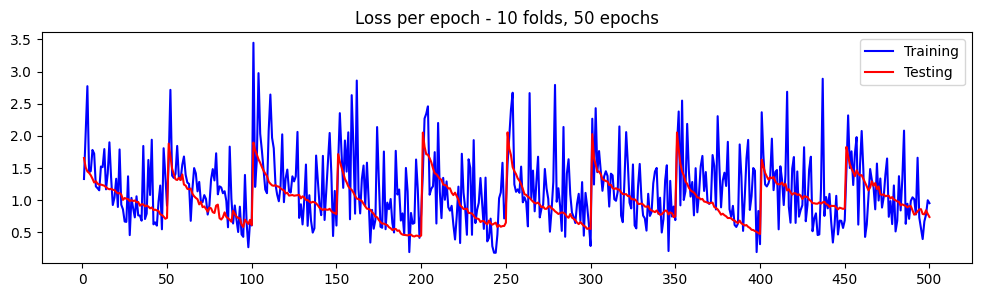

In [20]:
loss_fig, loss_ax = plt.subplots(figsize=(12,3))
plt.plot(range(1,len(training_loss_list)+1), training_loss_list, color="blue")
plt.plot(range(1,len(testing_loss_list)+1), testing_loss_list, color="red")

loss_ax.set_title(f"Loss per epoch - {fold_count} folds, {epoch_count} epochs")
loss_ax.legend(["Training", "Testing"])
loss_ax.set_xticks(range(0, (epoch_count * fold_count + 1), 50))

[0.22729693353176117,
 0.6443146467208862,
 0.26425817608833313,
 0.23453468084335327,
 0.08740594983100891,
 0.48098668456077576,
 0.18352524936199188,
 0.22139829397201538,
 0.04304681345820427,
 0.24404507875442505]

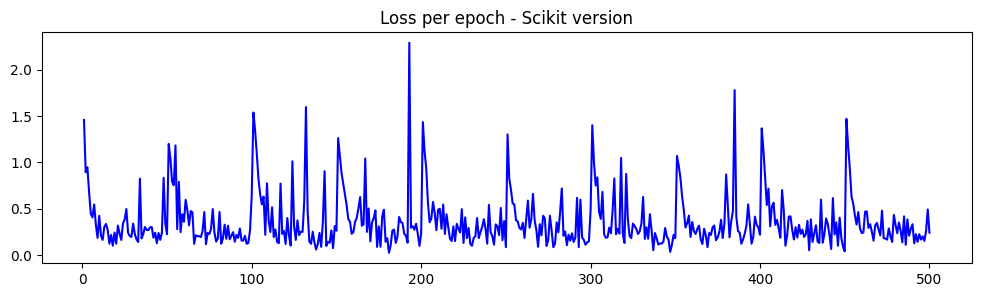

In [21]:
loss_fig, loss_ax = plt.subplots(figsize=(12,3))
plt.plot(range(1,len(scikit_loss_list)+1), scikit_loss_list, color="blue")
loss_ax.set_title("Loss per epoch - Scikit version")
scikit_loss_per_fold

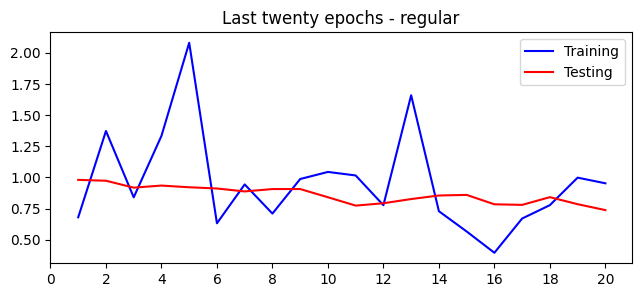

In [22]:
last_training_loss_list = training_loss_list[-20:]
last_testing_loss_list = testing_loss_list[-20:]

loss_fig, loss_ax = plt.subplots(figsize=(7.5,3))
plt.plot(range(1,len(last_training_loss_list)+1), last_training_loss_list, color="blue")
plt.plot(range(1,len(last_testing_loss_list)+1), last_testing_loss_list, color="red")

loss_ax.set_title("Last twenty epochs - regular")
loss_ax.legend(["Training", "Testing"])
loss_ax.set_xticks(range(0, 21, 2))